In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import numpy as np
import re
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc

In [31]:
nltk.download('punkt')  # For word_tokenize
nltk.download('stopwords')  # For stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulschmidinger/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulschmidinger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
# Load the dataset
data = pd.read_csv('../data/SMSSpamCollection.csv', sep='\t', header=None, names=['Label', 'Message'])

In [33]:
# Quick overview of the dataset
data.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [34]:
#count all rows
data.shape

(5572, 2)

In [35]:
# Check for missing values
data.isnull().sum()

Label      0
Message    0
dtype: int64

In [36]:
# Tokenization and Stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_message(message):
    tokens = word_tokenize(message)
    tokens = [word.lower() for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

data['Processed Message'] = data['Message'].apply(preprocess_message)

In [37]:
# Class distribution
class_counts = data['Label'].value_counts()
print(class_counts)

#add percentage
class_counts_perc = data['Label'].value_counts(normalize=True)
class_counts_perc

Label
ham     4825
spam     747
Name: count, dtype: int64


Label
ham     0.865937
spam    0.134063
Name: proportion, dtype: float64

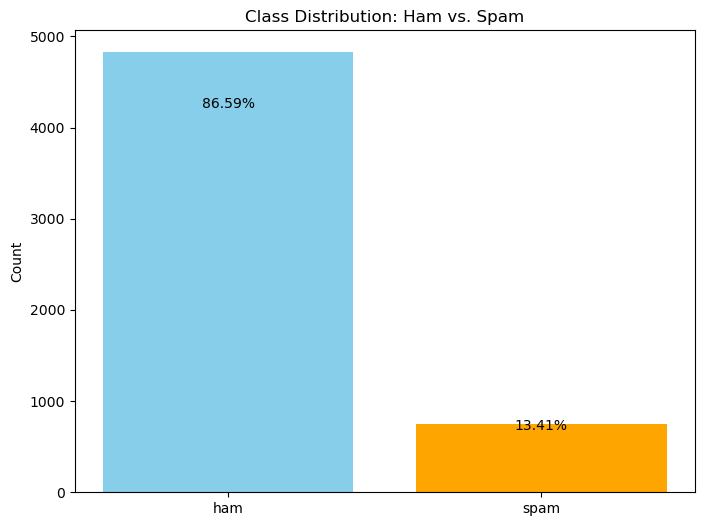

In [38]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'orange'])
plt.title('Class Distribution: Ham vs. Spam')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(class_counts_perc
):
    plt.text(i, v*class_counts.max(), f'{v:.2%}', color='black', va='bottom', ha='center')  
plt.savefig('../evaluation/class_distribution.png')
plt.show()


In [39]:
# Message length analysis
data['Message Length'] = data['Message'].apply(len)

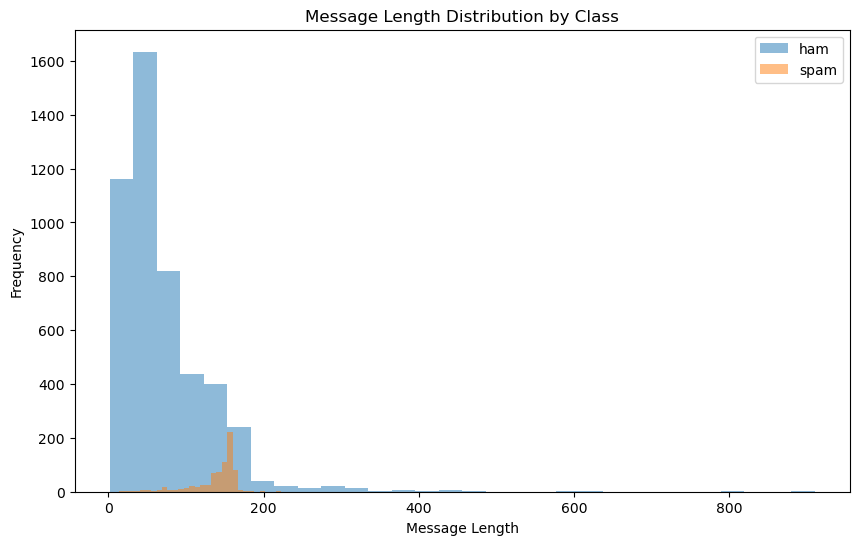

In [40]:
# Visualize message length distribution
plt.figure(figsize=(10, 6))
for label in data['Label'].unique():
    subset = data[data['Label'] == label]
    plt.hist(subset['Message Length'], bins=30, alpha=0.5, label=label)
plt.title('Message Length Distribution by Class')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('../evaluation/message_length.png')
plt.show()

In [41]:
# Message length statistics by class
data.groupby('Label')['Message Length'].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


In [42]:
# WordCloud visualization for Spam and Ham
spam_words = ' '.join(data[data['Label'] == 'spam']['Processed Message'])
ham_words = ' '.join(data[data['Label'] == 'ham']['Processed Message'])

# Split the concatenated string into individual words
spam_words_list = spam_words.split()
ham_words_list = ham_words.split()

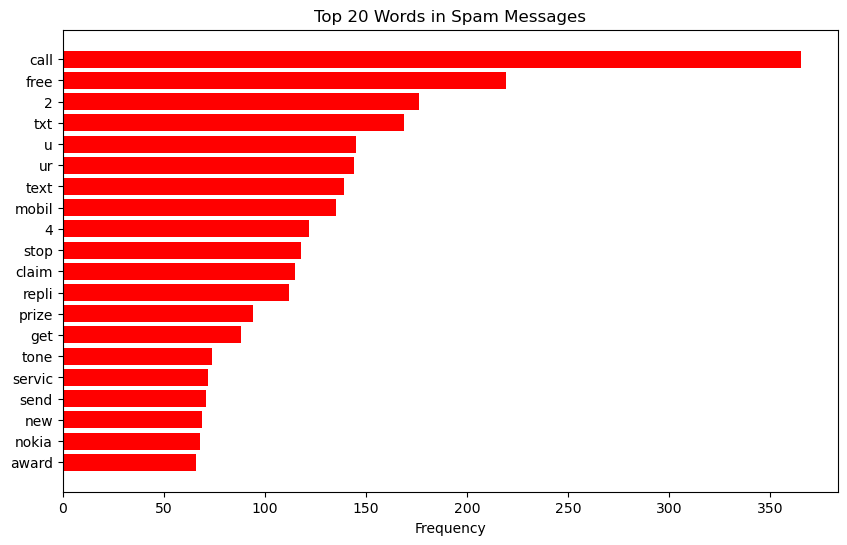

In [43]:
# Top 20 words for Spam
spam_word_counts = Counter(spam_words_list).most_common(20)
spam_words, spam_counts = zip(*spam_word_counts)
plt.figure(figsize=(10, 6))
plt.barh(spam_words, spam_counts, color='red')
plt.title('Top 20 Words in Spam Messages')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()
plt.savefig('../evaluation/top20_spam.png')
plt.show()

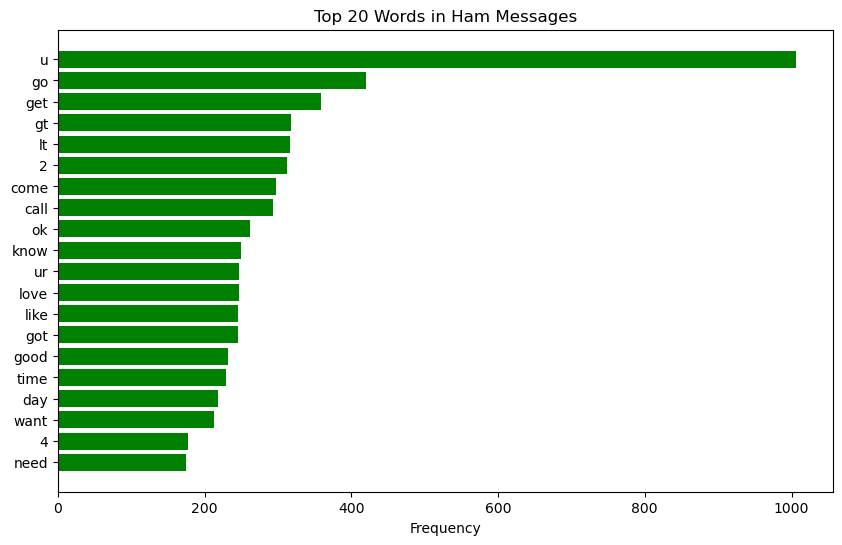

In [44]:
# Top 20 words for Ham
ham_word_counts = Counter(ham_words_list).most_common(20)
ham_words, ham_counts = zip(*ham_word_counts)
plt.figure(figsize=(10, 6))
plt.barh(ham_words, ham_counts, color='green')
plt.title('Top 20 Words in Ham Messages')
plt.xlabel('Frequency')
plt.gca().invert_yaxis()
plt.savefig('../evaluation/top20_ham.png')
plt.show()

In [45]:
# Convert text to numerical format using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Processed Message'])
y = data['Label']

# Encode labels
data['Label'] = data['Label'].map({'ham': 0, 'spam': 1})
y = data['Label']

In [46]:
# Apply Oversampling or Undersampling if necessary
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

In [47]:
print("\nClass Balance After Oversampling:")
print(pd.Series(y_resampled).value_counts())


Class Balance After Oversampling:
Label
0    4825
1    4825
Name: count, dtype: int64


In [48]:
with open('../evaluation/data_summary.txt', 'w') as f:
    f.write("Dataset Overview:\n")
    f.write(str(data.head()))
    f.write("\n\nTotal Rows:\n")
    f.write(str(data.shape))
    f.write("\n\nMissing Values:\n")
    f.write(str(data.isnull().sum()))
    f.write("\n\nClass Distribution before Sampling:\n")
    f.write(str(class_counts))
    f.write("\n\nClass Distribution (%) before Sampling:\n")
    f.write(str(class_counts_perc))
    f.write("\n\nClass Balance After Oversampling:\n")
    f.write(str(pd.Series(y_resampled).value_counts()))
    f.write("\n\nMessage Length Statistics:\n")
    f.write(str(data['Message Length'].describe()))
    f.write("\n\nTop 20 Words in Spam Messages:\n")
    f.write(str(spam_word_counts))
    f.write("\n\nTop 20 Words in Ham Messages:\n")
    f.write(str(ham_word_counts))

print("Analysis complete. Summary saved to 'data_summary.txt'.")

Analysis complete. Summary saved to 'data_summary.txt'.


In [49]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [50]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    print(f"\nTraining and evaluating: {model_name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nAccuracy Score: {accuracy}\n")


Training and evaluating: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       990
           1       0.99      0.98      0.99       940

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930


Confusion Matrix:
[[980  10]
 [ 15 925]]

Accuracy Score: 0.9870466321243523


Training and evaluating: Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       990
           1       0.97      0.98      0.98       940

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930


Confusion Matrix:
[[958  32]
 [ 15 925]]

Accuracy Score: 0.9756476683937824


Training and evaluating: Random Forest

Classification 

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:32:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       990
           1       0.99      0.99      0.99       940

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930


Confusion Matrix:
[[981   9]
 [  6 934]]

Accuracy Score: 0.9922279792746114



In [51]:
# Save comparison results
with open('../evaluation/model_comparison_results.txt', 'w') as f:
    for model_name, accuracy in results.items():
        f.write(f"{model_name}: {accuracy}\n")

# Identify the best model
best_model = max(results, key=results.get)
print(f"Best model: {best_model} with accuracy {results[best_model]}")

Best model: Random Forest with accuracy 1.0


In [52]:
# Save the best model results to a file
with open('../evaluation/best_model_results.txt', 'w') as f:
    f.write(f"Best Model: {best_model}\n")
    f.write(f"Accuracy: {results[best_model]}\n")

print("Model training and evaluation complete. Results saved to 'model_comparison_results.txt' and 'best_model_results.txt'.")


Model training and evaluation complete. Results saved to 'model_comparison_results.txt' and 'best_model_results.txt'.


In [53]:
#save best model
joblib.dump(models[best_model], '../models/spam_classifier.pkl')
print("Best model saved as 'spam_classifier.pkl'.")

Best model saved as 'spam_classifier.pkl'.


In [54]:
# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

In [55]:
# Define thresholds for risk levels
low_risk_threshold = 0.9  # High threshold for low risk
high_risk_threshold = 0.5  # Lower threshold for high risk

# Adjust predictions based on thresholds
low_risk_predictions = (y_prob > low_risk_threshold).astype(int)
high_risk_predictions = (y_prob > high_risk_threshold).astype(int)

# Evaluate thresholds
print("\nLow-Risk Threshold Evaluation:")
print(classification_report(y_test, low_risk_predictions))
print("\nHigh-Risk Threshold Evaluation:")
print(classification_report(y_test, high_risk_predictions))


Low-Risk Threshold Evaluation:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       990
           1       1.00      0.88      0.93       940

    accuracy                           0.94      1930
   macro avg       0.95      0.94      0.94      1930
weighted avg       0.95      0.94      0.94      1930


High-Risk Threshold Evaluation:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       990
           1       0.99      0.99      0.99       940

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



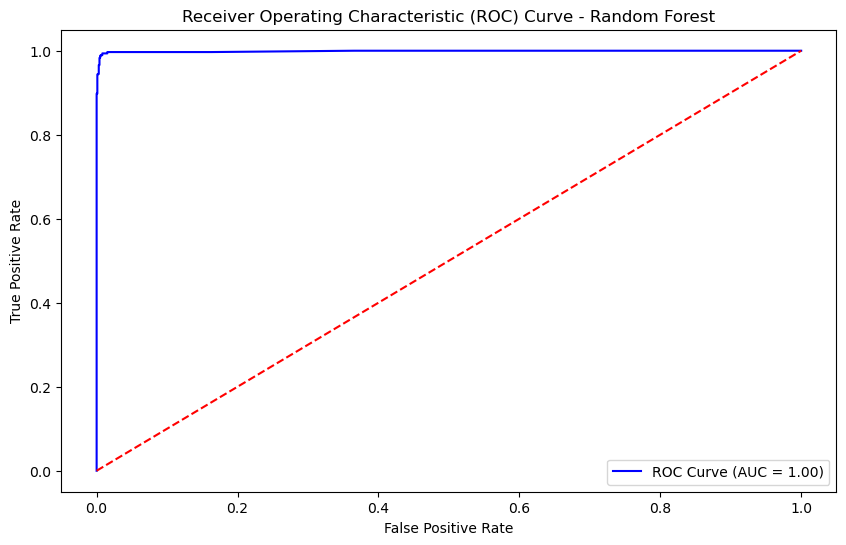

In [56]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('../evaluation/roc_curve_random_forest.png')
plt.show()

In [60]:
# Analyze misclassifications
false_negatives = np.where((y_test == 1) & (y_pred == 0))[0]
false_positives = np.where((y_test == 0) & (y_pred == 1))[0]


print (false_negatives.shape)
print(false_positives.shape)

if len(false_negatives) == 0 and len(false_positives) == 0:
    print("\nNo misclassifications found.")
else:
    # Extract misclassified messages with probabilities
    false_negative_messages = pd.DataFrame({
        'Message': data.iloc[false_negatives]['Message'],
        'Probability': y_prob[false_negatives]
    })
    false_positive_messages = pd.DataFrame({
        'Message': data.iloc[false_positives]['Message'],
        'Probability': y_prob[false_positives]
    })

    print("\nFalse Negatives (Spam classified as Ham):")
    print(false_negative_messages)
    print("\nFalse Positives (Ham classified as Spam):")
    print(false_positive_messages)

(6,)
(9,)

False Negatives (Spam classified as Ham):
                                                Message  Probability
86    For real when u getting on yo? I only need 2 m...     0.431241
267     Not sure yet, still trying to get a hold of him     0.035046
938                            K:)k.are you in college?     0.035046
1166        Haha yeah I see that now, be there in a sec     0.431241
1181                         I'm in chennai velachery:)     0.431241
1207  As a SIM subscriber, you are selected to recei...     0.035046

False Positives (Ham classified as Spam):
                                                Message  Probability
561                          Hi msg me:)i'm in office..     0.507785
717   +449071512431 URGENT! This is the 2nd attempt ...     0.554094
860             Did he just say somebody is named tampa     0.587249
872   Its going good...no problem..but still need li...     0.881164
1142  I don't know u and u don't know me. Send CHAT ...     0.553824
1201   

In [63]:
    # Identify common patterns in misclassified messages
    def find_common_words(messages):
        all_words = ' '.join(messages).split()
        word_counts = pd.Series(all_words).value_counts().head(10)
        return word_counts

    def calculate_average_length(messages):
        return messages.apply(len).mean()

    def count_patterns(messages, pattern):
        return messages.apply(lambda x: len(re.findall(pattern, x))).sum()

    common_false_negatives = find_common_words(false_negative_messages['Message'])
    common_false_positives = find_common_words(false_positive_messages['Message'])

    avg_length_false_negatives = calculate_average_length(false_negative_messages['Message'])
    avg_length_false_positives = calculate_average_length(false_positive_messages['Message'])

    exclamation_count_false_negatives = count_patterns(false_negative_messages['Message'], r'!')
    exclamation_count_false_positives = count_patterns(false_positive_messages['Message'], r'!')

    uppercase_count_false_negatives = count_patterns(false_negative_messages['Message'], r'[A-Z]{2,}')
    uppercase_count_false_positives = count_patterns(false_positive_messages['Message'], r'[A-Z]{2,}')

    print("\nCommon Words in False Negatives:")
    print(common_false_negatives)

    print("\nCommon Words in False Positives:")
    print(common_false_positives)

    print(f"\nAverage Message Length in False Negatives: {avg_length_false_negatives}")
    print(f"Average Message Length in False Positives: {avg_length_false_positives}")

    print(f"\nExclamation Marks in False Negatives: {exclamation_count_false_negatives}")
    print(f"Exclamation Marks in False Positives: {exclamation_count_false_positives}")

    print(f"\nUppercase Words in False Negatives: {uppercase_count_false_negatives}")
    print(f"Uppercase Words in False Positives: {uppercase_count_false_positives}")



Common Words in False Negatives:
to             5
a              4
in             3
I              3
you            2
and            2
I'm            2
more           2
are            1
subscriber,    1
Name: count, dtype: int64

Common Words in False Positives:
and      4
the      4
to       4
my       3
u        2
know     2
don't    2
have     2
on       2
is       2
Name: count, dtype: int64

Average Message Length in False Negatives: 68.16666666666667
Average Message Length in False Positives: 94.0

Exclamation Marks in False Negatives: 1
Exclamation Marks in False Positives: 3

Uppercase Words in False Negatives: 3
Uppercase Words in False Positives: 10


In [64]:
# Save comparison results
with open('../evaluation/risk_threshold_evaluation_random_forest.txt', 'w') as f:
    f.write("Low-Risk Threshold Evaluation:\n")
    f.write(classification_report(y_test, low_risk_predictions))
    f.write("\nHigh-Risk Threshold Evaluation:\n")
    f.write(classification_report(y_test, high_risk_predictions))
    if len(false_negatives) == 0 and len(false_positives) == 0:
        f.write("\nNo misclassifications found.\n")
    else:
        f.write("\n\nFalse Negatives (Spam classified as Ham):\n")
        f.write(false_negative_messages.to_string())
        f.write("\n\nFalse Positives (Ham classified as Spam):\n")
        f.write(false_positive_messages.to_string())
        f.write("\n\nCommon Words in False Negatives:\n")
        f.write(str(common_false_negatives))
        f.write("\n\nCommon Words in False Positives:\n")
        f.write(str(common_false_positives))
        f.write(f"\n\nAverage Message Length in False Negatives: {avg_length_false_negatives}\n")
        f.write(f"Average Message Length in False Positives: {avg_length_false_positives}\n")
        f.write(f"\nExclamation Marks in False Negatives: {exclamation_count_false_negatives}\n")
        f.write(f"Exclamation Marks in False Positives: {exclamation_count_false_positives}\n")
        f.write(f"\nUppercase Words in False Negatives: {uppercase_count_false_negatives}\n")
        f.write(f"Uppercase Words in False Positives: {uppercase_count_false_positives}\n")

print("Threshold evaluations, ROC Curve, and misclassification analysis complete. Results saved to 'risk_threshold_evaluation_random_forest.txt' and 'roc_curve_random_forest.png'.")


Threshold evaluations, ROC Curve, and misclassification analysis complete. Results saved to 'risk_threshold_evaluation_random_forest.txt' and 'roc_curve_random_forest.png'.
